<img src="https://github.com/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/img/nb_logo.png?raw=1" width="600">

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/notebooks/embeddings.ipynb)


This is a version of the notebook from [SETH](https://github.com/DagmarIlz/SETH) --- [here](https://colab.research.google.com/drive/1vDWh5YI_BPxQg0ku6CxKtSXEJ25u2wSq?usp=sharing).

In [ ]:
!pip install "transformers[torch]" sentencepiece h5py biopython > /dev/null

<h3><span style="color:red">Important</span></h3> 
If you are running in Google Colab, change the Notebook settings to use `GPU`.

Just follow **Edit** > **Notebook settings** or **Runtime** > **Change runtime type** and select **GPU** as Hardware accelerator.

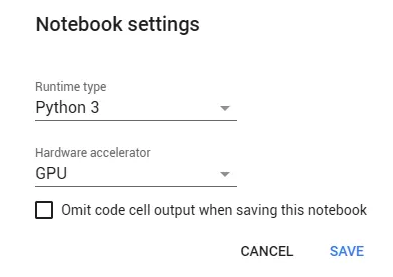


# Embeddings

This tutorial demonstrates how to train a simple variant predictor, i.e. we predict the biological activity of mutations of a protein, using fixed embeddings from ESM. You can adopt a similar protocol to train a model for any downstream task, even with limited data.

We will use a simple classifier in sklearn (or "head" on top of the transformer features) to predict the mutation effect from precomputed ESM embeddings. The embeddings for your dataset can be dumped once using a GPU. Then, the rest of your analysis can be done on CPU.


In [ ]:
#Set up working directories and download files/checkpoints. { display-mode: "form" }
!mkdir protT5 # directory for storing checkpoints, results etc
!mkdir protT5/output # directory for storing your embeddings
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta !curl -O protT5/P62593.fasta

In [ ]:
# Import dependencies and check whether GPU is available. { display-mode: "form" }
from transformers import T5EncoderModel, T5Tokenizer
import torch
import h5py
import time
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))

In [ ]:
from Bio import SeqIO

def read_fasta(fasta_path):
  seqs = {}
  with open(fasta_path) as handle:
      for record in SeqIO.parse(handle, "fasta"):
        seqs[record.id] = record.seq

  example_id=next(iter(seqs))
  print("Read {} sequences.".format(len(seqs)))
  print("Example:\n{}\n{}".format(example_id,seqs[example_id]))

  return seqs

## Model ProtT5-XL-UniRef50

ProtT5-XL-UniRef50 is based on the t5-3b model and was pretrained on a large corpus of protein sequences in a self-supervised fashion. This means it was pretrained on the raw protein sequences only, with **no humans-in-the-loop labelling** them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those protein sequences.

This model only contains the encoder portion of the original ProtT5-XL-UniRef50 model using half precision (float16). As such, this model can efficiently be used to create protein/ amino acid representations. When used for training downstream networks/ feature extraction, these embeddings produced the same performance (established empirically by comparing on several downstream tasks).

In [ ]:
# Load encoder-part of ProtT5 in half-precision. { display-mode: "form" }
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50) 
def get_T5_model():
  model_checkpoint = 'Rostlab/prot_t5_xl_half_uniref50-enc'
  model = T5EncoderModel.from_pretrained(model_checkpoint)
  model = model.to(device) # move model to GPU
  model = model.eval() # set model to evaluation model
  tokenizer = T5Tokenizer.from_pretrained(model_checkpoint)
  
  return model, tokenizer

In [ ]:
Generate embeddings. { display-mode: "form" }
# Generate embeddings via batch-processing
# max_seq_len gives the upper sequences length for applying batch-processing
# max_batch gives the upper number of sequences per batch
def get_embeddings( model, tokenizer, seqs, max_seq_len=1000, max_batch=100 ):

    results = {"protein_embs" : dict()}

    # sort sequences according to length (reduces unnecessary padding --> speeds up embedding)
    seq_dict   = sorted( seqs.items(), key=lambda kv: len( seqs[kv[0]] ), reverse=True )
    start = time.time()
    batch = list()
    for seq_idx, (pdb_id, seq) in enumerate(seq_dict,1):
        seq = ' '.join(list(seq))
        seq_len = len(seq)
        batch.append((pdb_id, seq, seq_len))

      
        pdb_ids, seqs, seq_lens = zip(*batch)
        batch = list()

        # add_special_tokens adds extra token at the end of each sequence
        token_encoding = tokenizer.batch_encode_plus(seqs, add_special_tokens=True, padding="longest")
        input_ids      = torch.tensor(token_encoding['input_ids']).to(device)
        attention_mask = torch.tensor(token_encoding['attention_mask']).to(device)
        
        try:
            with torch.no_grad():
                embedding_repr = model(input_ids, attention_mask=attention_mask)
        except RuntimeError:
            print("RuntimeError during embedding for {} (L={})".format(pdb_id, seq_len))
            continue

        for batch_idx, identifier in enumerate(pdb_ids): # for each protein in the current mini-batch
            s_len = seq_lens[batch_idx]
            # slice off padding --> batch-size x seq_len x embedding_dim  
            emb = embedding_repr.last_hidden_state[batch_idx,:s_len]
            protein_emb = emb.mean(dim=0)
            results["protein_embs"][identifier] = protein_emb.detach().cpu().numpy().squeeze()


    passed_time=time.time()-start
    avg_time = passed_time/len(results["protein_embs"])
    print('\n############# EMBEDDING STATS #############')
    print('Total number of per-protein embeddings: {}'.format(len(results["protein_embs"])))
    print("Time for generating embeddings: {:.1f}[m] ({:.3f}[s/protein])".format(
        passed_time/60, avg_time ))
    print('\n############# END #############')
    return results

In [ ]:
Write embeddings to disk. { display-mode: "form" }
def save_embeddings(emb_dict,out_path):
    with h5py.File(str(out_path), "w") as hf:
        for sequence_id, embedding in emb_dict.items():
            # noinspection PyUnboundLocalVariable
            hf.create_dataset(sequence_id, data=embedding)
    return None

In [ ]:
per_protein_path = "./protT5/output/per_protein_embeddings.h5" # where to store the embeddings
seq_path = 'P62593.fasta'
# Load example fasta.
seqs = read_fasta( seq_path )

# Load the encoder part of ProtT5-XL-U50 in half-precision (recommended)
model, tokenizer = get_T5_model()

# Compute embeddings and/or secondary structure predictions
results = get_embeddings( model, tokenizer, seqs)

save_embeddings(results["protein_embs"], per_protein_path)


In [ ]:
ys = []
Xs = []

for key in embeddings:
  scaled_effect = key.split('|')[-1]
  ys.append(float(scaled_effect))
  Xs.append(embeddings[key])
Xs = torch.stack(Xs, dim=0).numpy()
print(len(ys))
print(Xs.shape)